# 1. Prerequisite

1. Importing required packages
2. Reading CSV and creating Data Frame
3. Understand the Data Frame

In [123]:
#Importing Required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')
# pd.set_option("display.max_rows", 50)

In [124]:
# Creating dataframe from CSV file
loan_data = pd.read_csv("./loan/loan.csv")

In [125]:
# Checking the data
display(loan_data.shape)
loan_data.head()


(39717, 111)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


# 2. Common Methods

The code for ploting the graph. All common method codes are placed in this session

In [126]:
def count_plot_with_percentage(ax, data, column, xtick_rotation=None):
    """
    Arguments
        - ax - axis to plot
        - data (DataFrame): The DataFrame containing the data.
        - category (str): hue
        - x (str): The column to be plotted on the x-axis.
        - xlabel (str): Label for the x-axis.
        - ylabel (str): Label for the y-axis.
        - title (str): Title for the plot.
        - xtick-rotation (int): Rotation value for x-axis ticks.
        - figsize (tuple): Size of the figure in (x, y) format
    Returns:
        None
    """
    crosstab = pd.crosstab(data[column], data['loan_status'],margins=True)
    # totalPer = crosstab.loc['All', 'All']
    # display(totalPer)
    
    #Charged off percentage = chared_off/total (fully paid + charged off count)
    crosstab['charged_off_percentage'] = round(((100*crosstab['Charged Off'])/crosstab['All']),2)
    # display(crosstab)
    
    crosstab = crosstab[0:-1]
 
    
    linePlot_chargedoff = crosstab[['charged_off_percentage']]
    barPlot =  crosstab.iloc[:,0:2]

    bar = barPlot.plot(kind='bar', ax=ax, stacked=True)
    bar.set_ylabel('Count')
    bar.set_title(f'{column} vs Loan Status')
    if xtick_rotation:
        bar.set_xticklabels(rotation=xtick_rotation)
    
    line = linePlot_chargedoff.plot(ax=ax, secondary_y=True, marker='o')
    line.set_ylabel('Percentage')
   


In [127]:
def round_to_nearest_1000(x):
    rounded = round(x / 1000) * 1000
    if rounded >= 1000:
        return f"{rounded // 1000}k"
    else:
        return str(rounded)

In [128]:
def get_valid_data_limits(data,  multiplier = 1.5) -> dict:
    quartile1 = data.quantile(0.25)
    quartile3 = data.quantile(0.75)
    iqr = quartile3 - quartile1
    lower_bound = quartile1 - multiplier * iqr
    upper_bound = quartile3 + multiplier * iqr
    return {
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    }

# 3. Data Cleaning

1. Drop the columns if,
    1. The missing values for that column is > 50%
    2. The column having only one value (unique count is 1) 
    3. The percentage of unique values in a column is less than 2% (e.g. URL - all values are unique)
2. Drop the rows,
    1. Remove duplicate rows 
    2. We are considering only Closed and Chargged of loans for few scenarios. So we can remove the loan with status 'Current'.
3. Outlier removal
    1. annual_inc

### 3.1 Check for duplicate Roles

In [129]:
# Checking for duplicate rows
display(loan_data[loan_data.duplicated()].shape)

(0, 111)

<font color="blue"> Summary: There are no duplicate rows </font>

### 3.2 Removing columns where missing values > 50%

In [130]:
# Find isnull values in dataset and get the percentage 
missing_values_percentage = loan_data.isnull().sum() / len(loan_data) * 100
print(missing_values_percentage)

id                              0.000000
member_id                       0.000000
loan_amnt                       0.000000
funded_amnt                     0.000000
funded_amnt_inv                 0.000000
                                 ...    
tax_liens                       0.098195
tot_hi_cred_lim               100.000000
total_bal_ex_mort             100.000000
total_bc_limit                100.000000
total_il_high_credit_limit    100.000000
Length: 111, dtype: float64


In [131]:
# Get coloumns with more than 50% of data
columns_with_missing_data = missing_values_percentage[missing_values_percentage > 50].index
print(columns_with_missing_data)

Index(['mths_since_last_delinq', 'mths_since_last_record', 'next_pymnt_d',
       'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint',
       'verification_status_joint', 'tot_coll_amt', 'tot_cur_bal',
       'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m',
       'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m',
       'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi',
       'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
       'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m',
       'num_t

In [132]:
# Drop the columns with more than 50% of miss_dataing data
loan_data = loan_data.drop(columns=columns_with_missing_data)

In [133]:
loan_data.shape

(39717, 54)

In [134]:
# Checking for the coloumns that still have some missing values
missing_value = loan_data.isnull().sum() / len(loan_data) * 100
find_missing_columns = missing_value[missing_value > 0]
print(find_missing_columns)

emp_title                      6.191303
emp_length                     2.706650
desc                          32.585543
title                          0.027696
revol_util                     0.125891
last_pymnt_d                   0.178765
last_credit_pull_d             0.005036
collections_12_mths_ex_med     0.140998
chargeoff_within_12_mths       0.140998
pub_rec_bankruptcies           1.754916
tax_liens                      0.098195
dtype: float64


<font color="blue"> Summary: Columns removed, remaining columns: 54 </font>

### 3.3 Removing columns based on the unique counts

In [135]:
# As we have reduce to 54 columns after data cleaning.
# Now we will again check for the columns with the unique counts in them.
unique_col = loan_data.nunique()
print(unique_col)

id                            39717
member_id                     39717
loan_amnt                       885
funded_amnt                    1041
funded_amnt_inv                8205
term                              2
int_rate                        371
installment                   15383
grade                             7
sub_grade                        35
emp_title                     28820
emp_length                       11
home_ownership                    5
annual_inc                     5318
verification_status               3
issue_d                          55
loan_status                       3
pymnt_plan                        1
url                           39717
desc                          26526
purpose                          14
title                         19615
zip_code                        823
addr_state                       50
dti                            2868
delinq_2yrs                      11
earliest_cr_line                526
inq_last_6mths              

In [136]:
# As per the above observation we got the columns with single unique value,
# so it will not affect the analysis
# remove the columns with unique count = 1
uni_col = unique_col[unique_col.values == 1]
unique_col_list = uni_col.index.tolist()
loan_data.drop(columns=unique_col_list, inplace=True)

In [137]:
loan_data.shape

(39717, 45)

In [138]:
# Columns where the number of unique values is greater than 2% 
per_unique_value = loan_data.nunique()
per_uni_col = per_unique_value[per_unique_value > len(loan_data)* .02]
print(per_uni_col)

id                         39717
member_id                  39717
loan_amnt                    885
funded_amnt                 1041
funded_amnt_inv             8205
installment                15383
emp_title                  28820
annual_inc                  5318
url                        39717
desc                       26526
title                      19615
zip_code                     823
dti                         2868
revol_bal                  21711
revol_util                  1089
out_prncp                   1137
out_prncp_inv               1138
total_pymnt                37850
total_pymnt_inv            37518
total_rec_prncp             7976
total_rec_int              35148
total_rec_late_fee          1356
recoveries                  4040
collection_recovery_fee     2616
last_pymnt_amnt            34930
dtype: int64


In [139]:
# After observing the data found that few columns will not  help in the analysis with following reasons so droping them
cols_not_required = ["url", "desc", "out_prncp", "out_prncp_inv", "id", "member_id"]
loan_data.drop(columns=cols_not_required, inplace=True)

In [140]:
loan_data.shape

(39717, 39)

<font color="blue"> Summary: Columns removed, remaining columns: 36 </font>

# 4. Data Preparation 

### 4.1 Analysing the data

In [141]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   loan_amnt                39717 non-null  int64  
 1   funded_amnt              39717 non-null  int64  
 2   funded_amnt_inv          39717 non-null  float64
 3   term                     39717 non-null  object 
 4   int_rate                 39717 non-null  object 
 5   installment              39717 non-null  float64
 6   grade                    39717 non-null  object 
 7   sub_grade                39717 non-null  object 
 8   emp_title                37258 non-null  object 
 9   emp_length               38642 non-null  object 
 10  home_ownership           39717 non-null  object 
 11  annual_inc               39717 non-null  float64
 12  verification_status      39717 non-null  object 
 13  issue_d                  39717 non-null  object 
 14  loan_status           

In [142]:
#By looking at the data, divided the columns into their category type
date_columns = ["issue_d"]
categorical_columns = ["grade", "sub_grade", "home_ownership", "verification_status", "loan_status", "purpose", "addr_state"]
numerical_columns= ["funded_amnt", "term", "int_rate", "installment", "emp_length", "annual_inc", "dti", "delinq_2yrs", "inq_last_6mths", "open_acc", "pub_rec", "revol_bal", "revol_util", "total_acc", "total_pymnt", "total_rec_prncp", "total_rec_int", "pub_rec_bankruptcies"]

In [143]:
categorical_columns.sort()
numerical_columns.sort()

In [144]:
#Now check for the dtype of the attributes
loan_data[date_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   issue_d  39717 non-null  object
dtypes: object(1)
memory usage: 310.4+ KB


In [145]:
loan_data[categorical_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   addr_state           39717 non-null  object
 1   grade                39717 non-null  object
 2   home_ownership       39717 non-null  object
 3   loan_status          39717 non-null  object
 4   purpose              39717 non-null  object
 5   sub_grade            39717 non-null  object
 6   verification_status  39717 non-null  object
dtypes: object(7)
memory usage: 2.1+ MB


In [146]:
loan_data[numerical_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   annual_inc            39717 non-null  float64
 1   delinq_2yrs           39717 non-null  int64  
 2   dti                   39717 non-null  float64
 3   emp_length            38642 non-null  object 
 4   funded_amnt           39717 non-null  int64  
 5   inq_last_6mths        39717 non-null  int64  
 6   installment           39717 non-null  float64
 7   int_rate              39717 non-null  object 
 8   open_acc              39717 non-null  int64  
 9   pub_rec               39717 non-null  int64  
 10  pub_rec_bankruptcies  39020 non-null  float64
 11  revol_bal             39717 non-null  int64  
 12  revol_util            39667 non-null  object 
 13  term                  39717 non-null  object 
 14  total_acc             39717 non-null  int64  
 15  total_pymnt        

### 4.2 Convert the values

In [147]:
#changing percentage
per_col = ["int_rate", "revol_util"]
for col in per_col:
    loan_data[col] = loan_data[col].str.strip('%').astype('float')

In [148]:
#Manipulating term data
loan_data["term"] = loan_data["term"].apply(lambda x : int(x.split()[0]))

In [149]:
#Date is in wrong format, so converting it into proper format
for col in date_columns:
    loan_data[col] = pd.to_datetime(loan_data[col], format = '%b-%y')

### 4.3 Derive new columns

In [150]:
# Derive year and month
loan_data['issue_year'] = pd.to_datetime(loan_data['issue_d']).dt.year
loan_data['issue_month'] = pd.to_datetime(loan_data['issue_d']).dt.month

### 4.4 Categorizing Data

In [151]:
# Interest rate category
bins = [0, 5, 10, 15, 20, 25]
labels = ['0-5', '5-10','10-15', '15-20', '20-25']
loan_data['int_rate_category'] = pd.cut(loan_data['int_rate'], bins=bins, labels=labels, right=False)

In [152]:
# Annual Income category, round of 1000s bucket
bins = np.linspace(loan_data['annual_inc'].min(), 150000, 10)
labels = [f"{round_to_nearest_1000(bins[i])}-{round_to_nearest_1000(bins[i + 1])}" for i in range(len(bins) - 1)]
bins = np.append(bins, np.inf) 
labels=np.append(labels,f'{round_to_nearest_1000(150000)}+') 
loan_data['annual_inc_category'] = pd.cut(loan_data['annual_inc'], bins=bins, labels=labels, right=False)

In [153]:
# Funded amount category, round of 1000s bucket
bins = np.linspace(loan_data['funded_amnt'].min(), loan_data['funded_amnt'].max(), 10)
labels = [f"{round_to_nearest_1000(bins[i])}-{round_to_nearest_1000(bins[i + 1])}" for i in range(len(bins) - 1)]
loan_data['funded_amnt_category'] = pd.cut(loan_data['funded_amnt'], bins=bins, labels=labels, right=False)

In [154]:
# Annual Income category, round of 1000s bucket
bins = np.linspace(loan_data['dti'].min(), loan_data['dti'].max(), 8)
labels = [f"{round(bins[i],2)}-{round(bins[i + 1],2)}" for i in range(len(bins) - 1)]
loan_data['dti_category'] = pd.cut(loan_data['dti'], bins=bins, labels=labels, right=False)

<font color="blue"> Summary: Categorized the data: int_rate_category, funded_amnt_category, funded_amnt_category, funded_amnt_category </font>

### 4.5 Converting Employee length value

In [155]:
emp_length_mapping: dict = {
    '< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3,
    '4 years': 4, '5 years': 5, '6 years': 6, '7 years': 7,
    '8 years': 8, '9 years': 9, '10+ years': 10
}

# Use the map function to replace values in the 'emp_length' column
loan_data['emp_length'] = loan_data['emp_length'].map(emp_length_mapping)

### 4.5 Treating Outliers

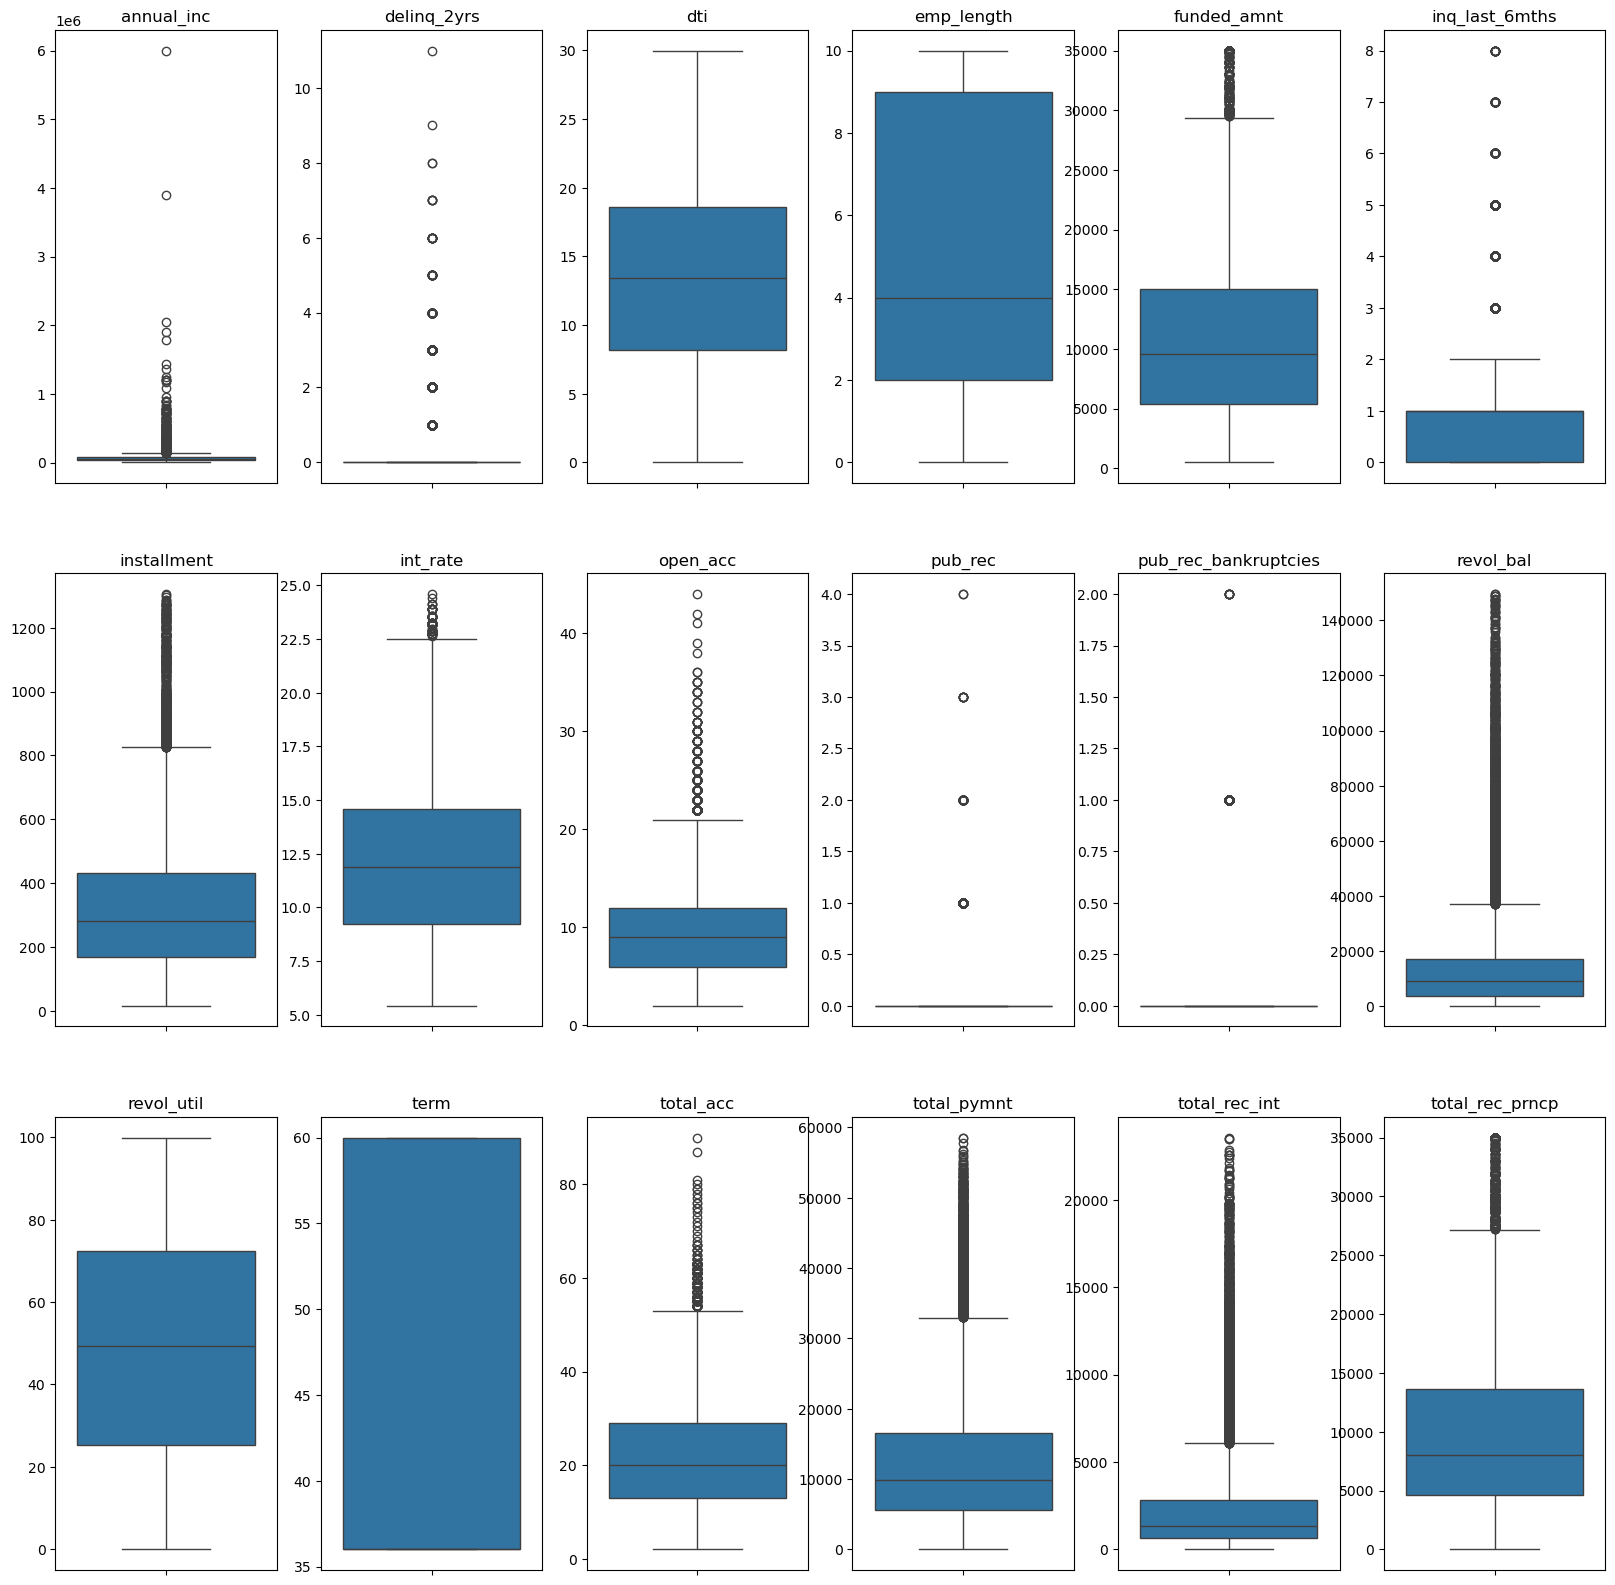

In [156]:
ncols=6
nrows=round(np.ceil(len(numerical_columns)/ncols))
fig, ax = plt.subplots(ncols=ncols,nrows=nrows, figsize=(20, 20))
ax = ax.flatten()
for index, column in enumerate(numerical_columns):
    sns.boxplot(data=(loan_data[column]), ax=ax[index])
    ax[index].set_title(column)
    ax[index].set_ylabel(None)
plt.show()

In [157]:
loan_data['annual_inc'].describe()

count    3.971700e+04
mean     6.896893e+04
std      6.379377e+04
min      4.000000e+03
25%      4.040400e+04
50%      5.900000e+04
75%      8.230000e+04
max      6.000000e+06
Name: annual_inc, dtype: float64

In [158]:
# Removing outlier for annual income
valid_data_dict = get_valid_data_limits(data=loan_data['annual_inc'], multiplier=2)
# valid_data_dict['upper_bound']
loan_data = loan_data[(loan_data['annual_inc'] < valid_data_dict['upper_bound'])]


In [159]:
loan_data['home_ownership'].value_counts()


home_ownership
RENT        18635
MORTGAGE    16817
OWN          2982
OTHER          94
NONE            3
Name: count, dtype: int64

In [160]:
#Imputing NONE values as OTHER for home_ownership

loan_data['home_ownership'].replace('NONE', 'OTHER', inplace = True)

### 4.6 Creating new variables for processing

In [161]:
#Remove rows where the loan_status is current as current means in-porgress
loan_data_without_current=loan_data.copy()
rows_to_drop = loan_data_without_current[loan_data['loan_status'] == "Current"].index
loan_data_without_current.drop(rows_to_drop, inplace=True)

In [162]:
#Filter the data
charged_off_loan_data = loan_data[loan_data['loan_status']=='Charged Off']
fully_paid_loan_data = loan_data[loan_data['loan_status']=='Fully Paid']

<font color="blue"> Summary: Converted the below columns </font>
1. Convert the data type
    1. int_rate
    2. term
    3. issue_date
2. Derive category bucket: interest rate, loan amount, Annual income and dti.
3. Derive Year and Month
4. Convert the Employee Length
5. Outliers - Outliers is not impacting the core columns (int_rate, funded_amnt, term, installment, emp_length), so not removing the rows. Will treat the outliers when required.

# 5. Univariate Analysis - For Charged Off Loans

## 5.1 For Categorical Fields

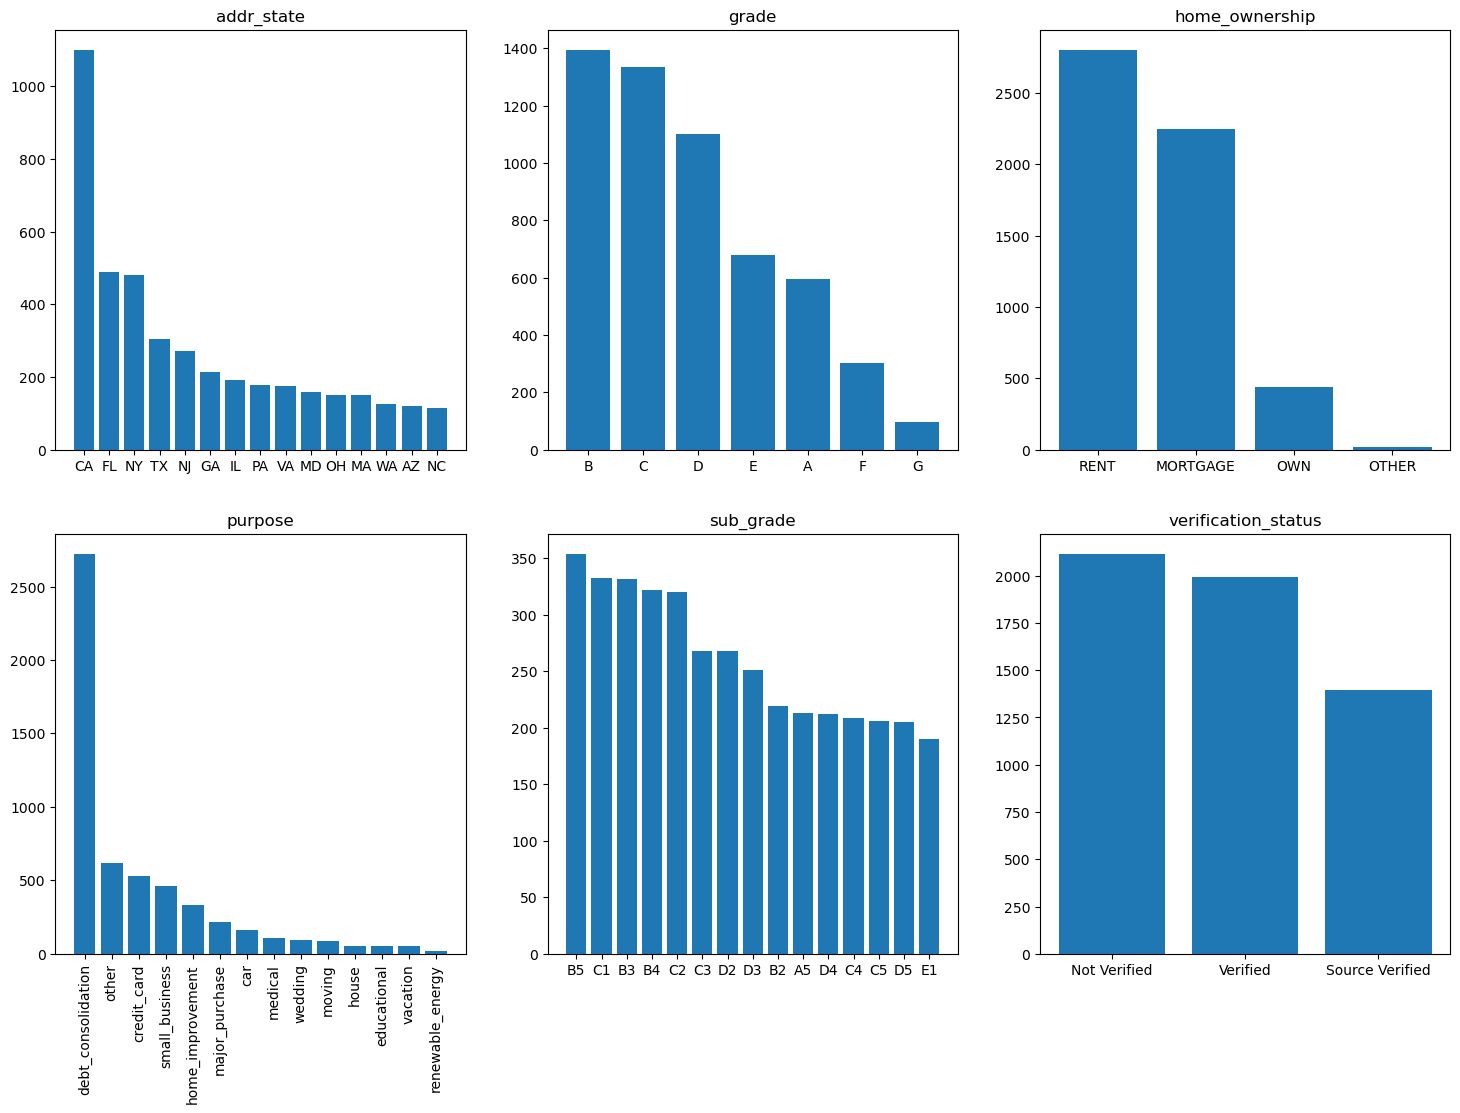

In [163]:
columns_to_plot=pd.Series(categorical_columns)
columns_to_plot = columns_to_plot[~columns_to_plot.isin(
    ['loan_status'])]
ncols=3
nrows=round(np.ceil(len(columns_to_plot)/ncols))
fig, ax = plt.subplots(ncols=ncols,nrows=nrows, figsize=(18, 12))
ax = ax.flatten()
for index, column in enumerate(columns_to_plot):
    df = charged_off_loan_data[column].value_counts()
    # Taking only top 15, because we are considering only charged off and we are more interested to analyze which value is contributing to default
    df = df.nlargest(15)
    ax[index].bar(df.index, df.values)
    # Rotating only if the values are lengthier
    if any(len(str(item)) > 15 for item in df.index):
        ax[index].set_xticklabels(df.index, rotation=90)
    ax[index].set_title(column)
plt.show()


## 5.2 For Numerical Fields

In [164]:
# Considering only the columns required for analysing loan_status
columns_to_plot=pd.Series(numerical_columns)
columns_to_plot = columns_to_plot[~columns_to_plot.isin(
    ['total_rec_prncp', 'total_rec_int', 'total_pymnt','revol_bal'
     'revol_util','revol_bal', 'pub_rec_bankruptcies','pub_rec'])]

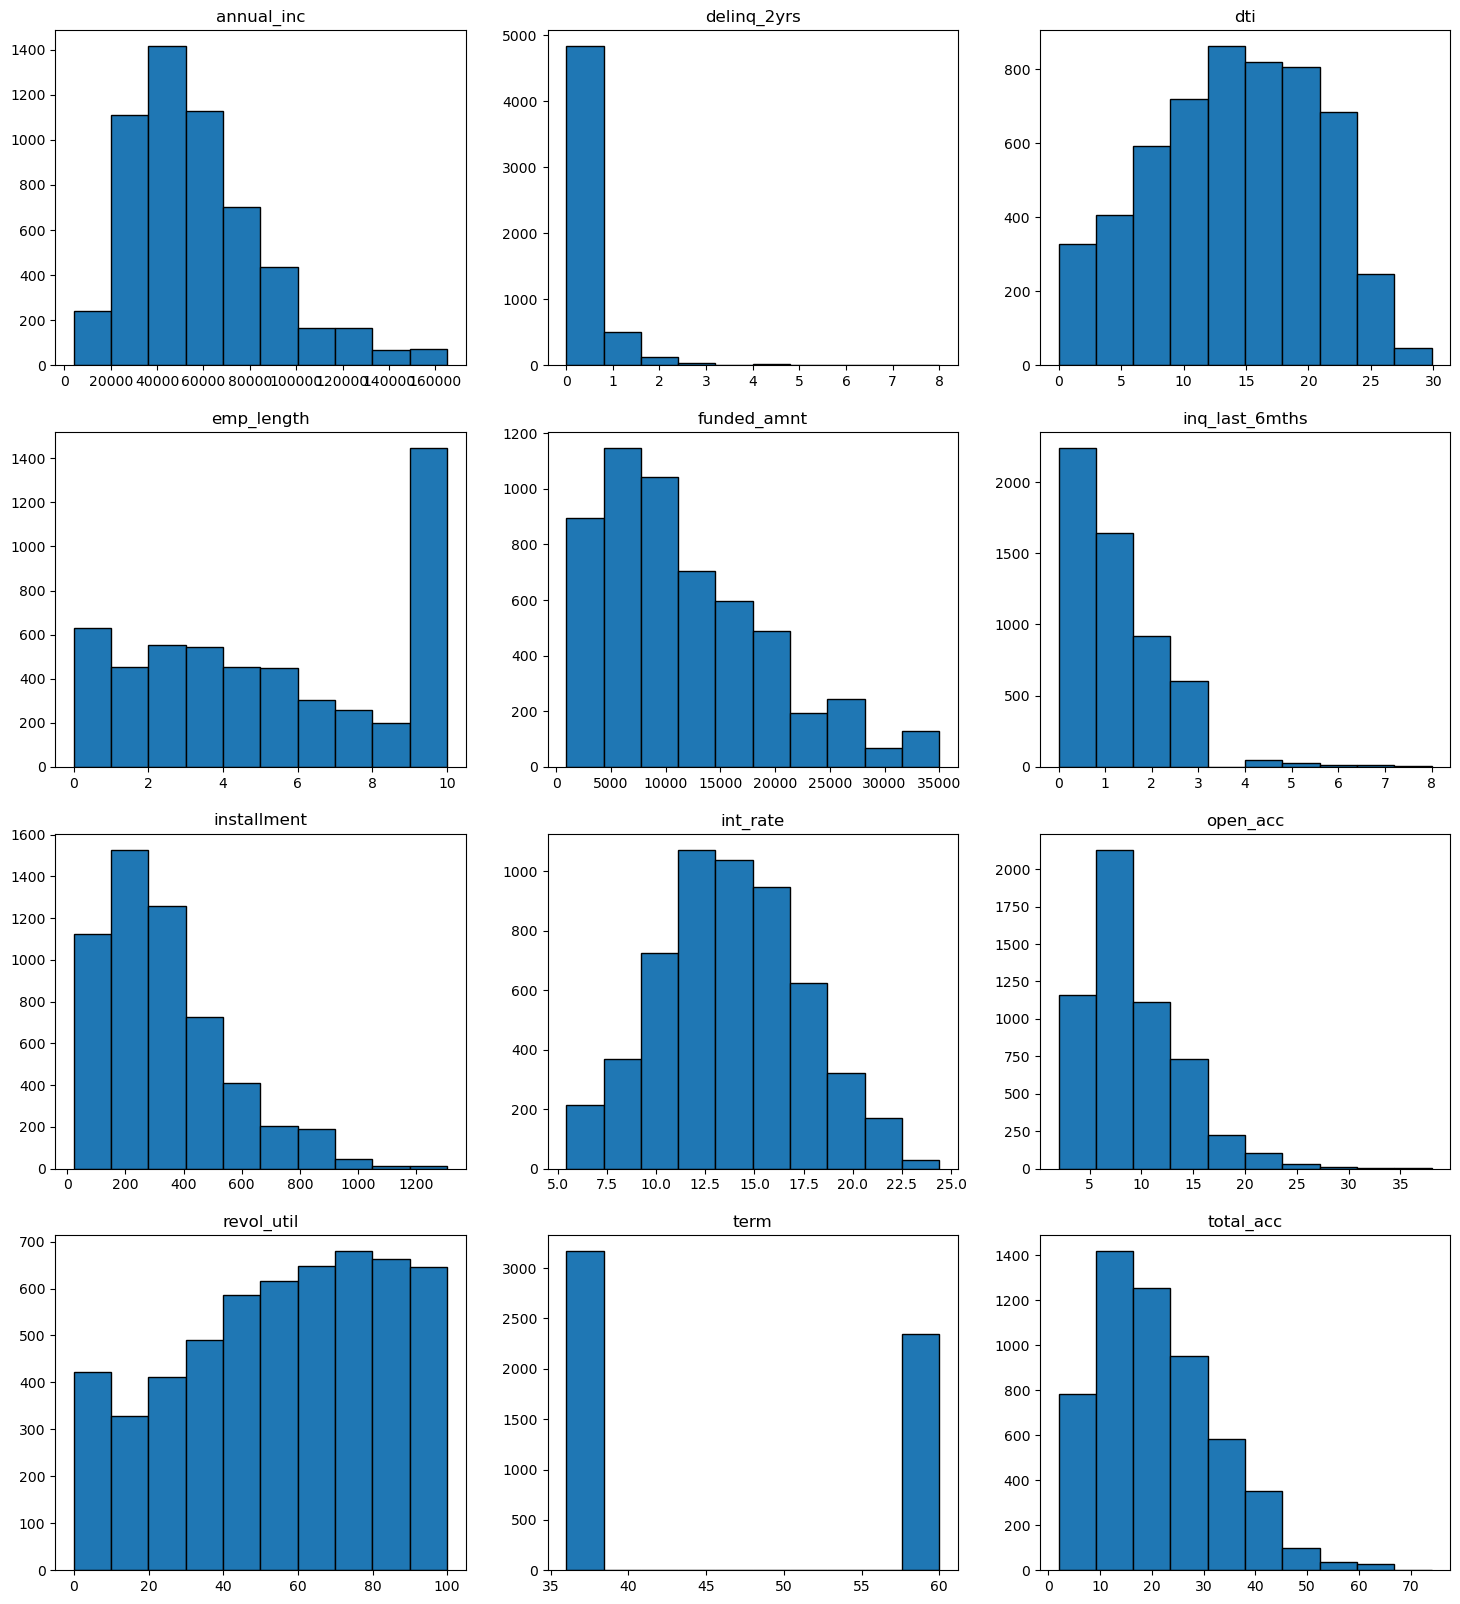

In [165]:
ncols=3
nrows=round(np.ceil(len(columns_to_plot)/ncols))
fig, ax = plt.subplots(ncols=ncols,nrows=nrows, figsize=(18, 20))
ax = ax.flatten()
for index, column in enumerate(columns_to_plot):
    ax[index].hist(x=charged_off_loan_data[column], edgecolor='black')
    ax[index].set_title(column)
plt.show()

Checking whether the below variables are contributing to loan charged off.
Considered only the columns which helps to identify whether a loan is charged off or not
- annual_inc
- delinq_2yrs
- dti
- emp_length
- funded_amnt
- inq_last_6mths
- installment
- int_rate
- open_acc
- revol_util
- term
- total_acc

In [166]:
#Resetting the style
plt.rcdefaults()

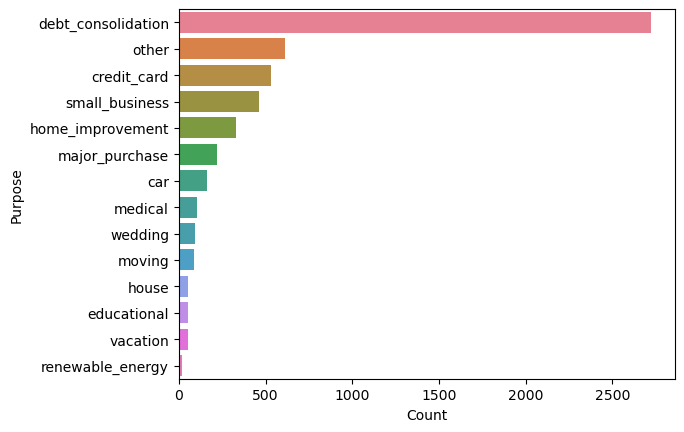

In [167]:
# Ploting a meaningfull graph for showing how purpose is impacting the loan charged of
df = charged_off_loan_data["purpose"].value_counts().reset_index()
df.columns = ['Purpose', 'Count']
colors = sns.color_palette("husl", len(df))
sns.barplot(data=df, y='Purpose', x='Count', palette=colors)
plt.show()

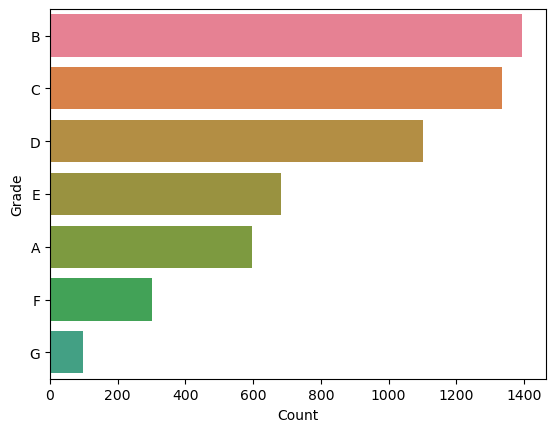

In [168]:
# Ploting a meaningfull graph for showing how Grade is impacting the loan charged of
df = charged_off_loan_data["grade"].value_counts().reset_index()
df.columns = ['Grade', 'Count']
sns.barplot(data=df, y='Grade', x='Count', palette=colors)
plt.show()

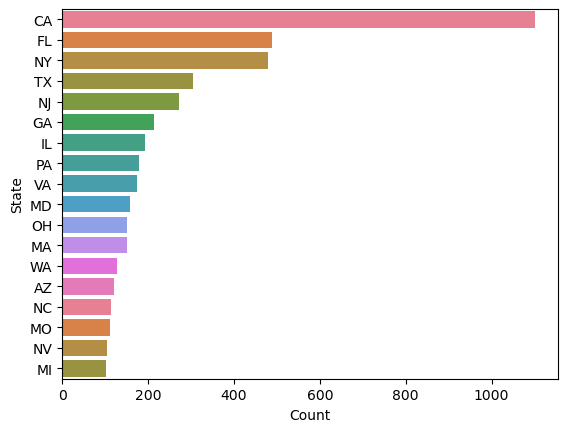

In [169]:
# Customer State vs charged off - plotting bar grarph, x axis is purpose, y axis is count
df = charged_off_loan_data["addr_state"].value_counts()
# Filtering again to plot the graph properly
df = df[df.values>100]
df=df.reset_index()
df.columns = ['State', 'Count']
sns.barplot(data=df, y='State', x='Count', palette=colors)
plt.show()

1. Consumer Attributes
    1. Consumer’s annual income between 35000 to 65000.
    2. Consumer’s DTI between 10 to 20.
    3. Borrower’s open credit lines is between 5 to 10.
    4. The loan purpose is for debt consolidation.
    5. Consumer is staying in the state CA.
    6. Consumer is staying on Rent or his home is on mortgage.
2. Loan Attributes
    1. The loan term is 36 months.
    2. Interest rate is between 10 to 15%.
    3. Grade is B or C.
    4. Verification status - verified is slightly better in terms of loan closure.
    5. Funded amount between 5000 to 12000.



# 6. Bi-Variate Analysis

## 6.1 Purpose vs Average Loan amount

Loan purpose vs requested amount. If a consumer is asking too much money for a ‘purpose’, then LC can reduce the loan amount.


In [170]:
# Since not much outliers and the data is normally distributed we can use mean
pt = pd.pivot_table(data=loan_data,index='purpose', values='funded_amnt')
pt = pt.astype(int)
df = pt.reset_index()
df.columns = ['Purpose', 'Average Loan Amount']
df

,Purpose,Average Loan Amount
0,car,6643
1,credit_card,11252
2,debt_consolidation,12212
3,educational,6625
4,home_improvement,10649
5,house,12131
6,major_purchase,7793
7,medical,7876
8,moving,6256
9,other,7679


## 6.2 Field categories vs Loan Status

1. The following fields will be analyzed in relation to Loan Status:
    1. Interest Rate Category
    2. Loan Amount category
    3. Annual income category
    4. DTI category

Purpose: The analysis aims to identify whether these fields contribute to loan charge-offs, and if so, to what extent (expressed as a percentage).

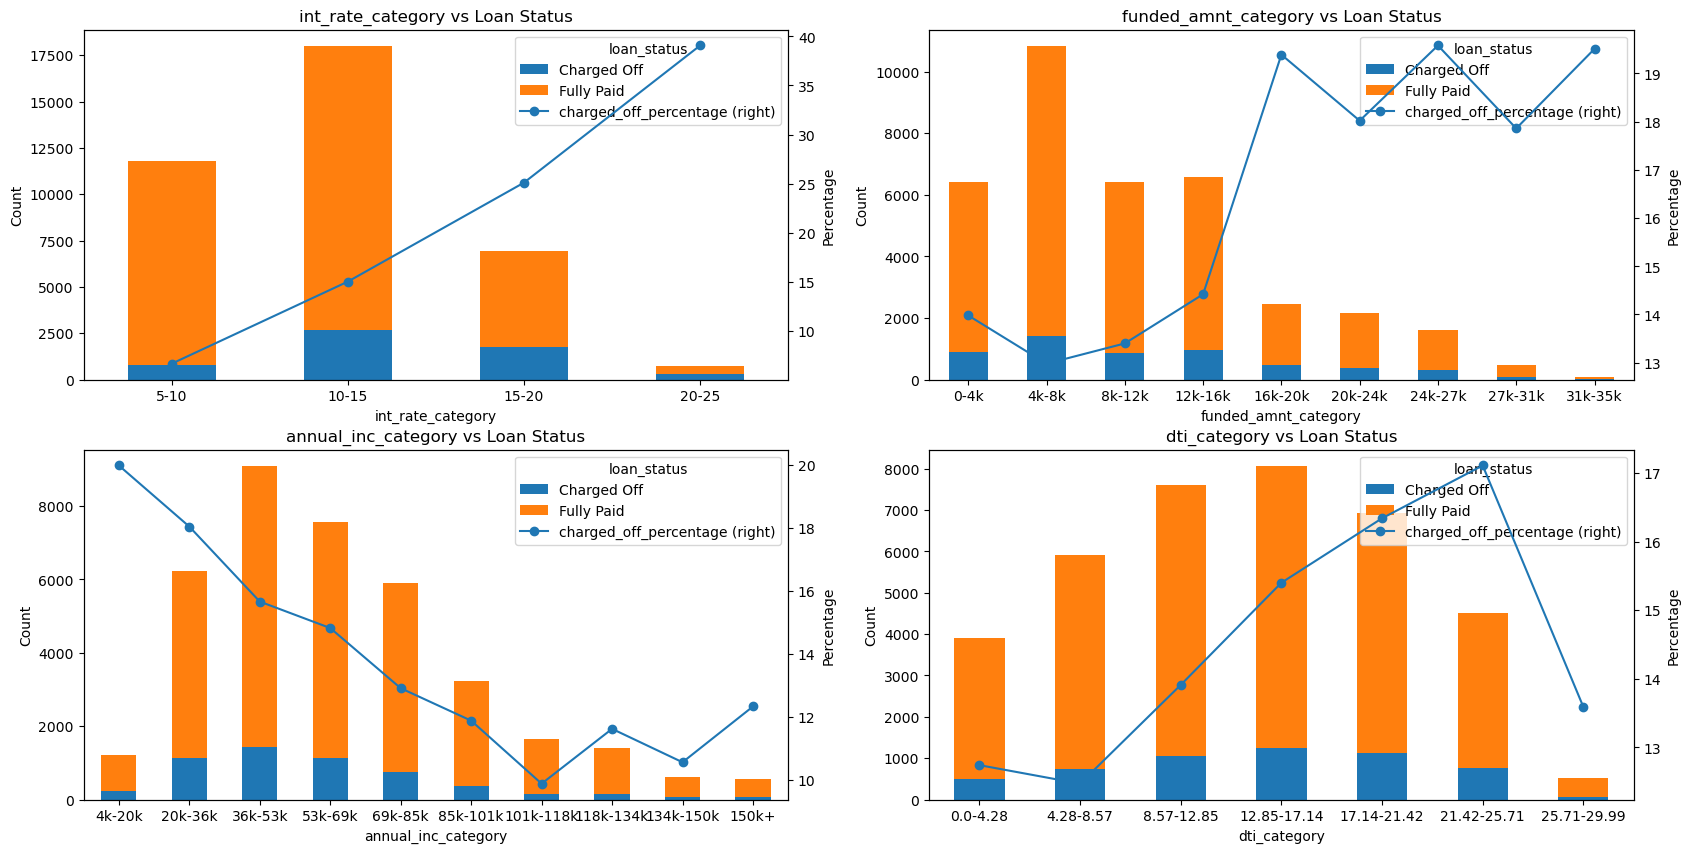

In [171]:
# Plotting the Bar (Count plot) and line (for percentage) for the below columns
columns_to_plot = ['int_rate_category', 'funded_amnt_category', 
                   'annual_inc_category', 'dti_category']
ncols=2
nrows=2
plt.rcdefaults()
fig, ax = plt.subplots(ncols= ncols,nrows=nrows, figsize=(20, 10))
ax = ax.flatten()
for index, value in enumerate(columns_to_plot):
    count_plot_with_percentage(ax[index], loan_data_without_current,
           column=value)
plt.show()

1. If the interest rate increases, the likelihood of the loan being charged off also increases.
2. The majority of loan amounts fall between 4000 and 8000, and there is a high probability that these loans will be fully repaid.
3. As annual income increases, the chances of a loan being charged off decrease.
4. The higher the DTI value, the greater the likelihood of the loan being charged off.


### 6.3 Attribute relationships

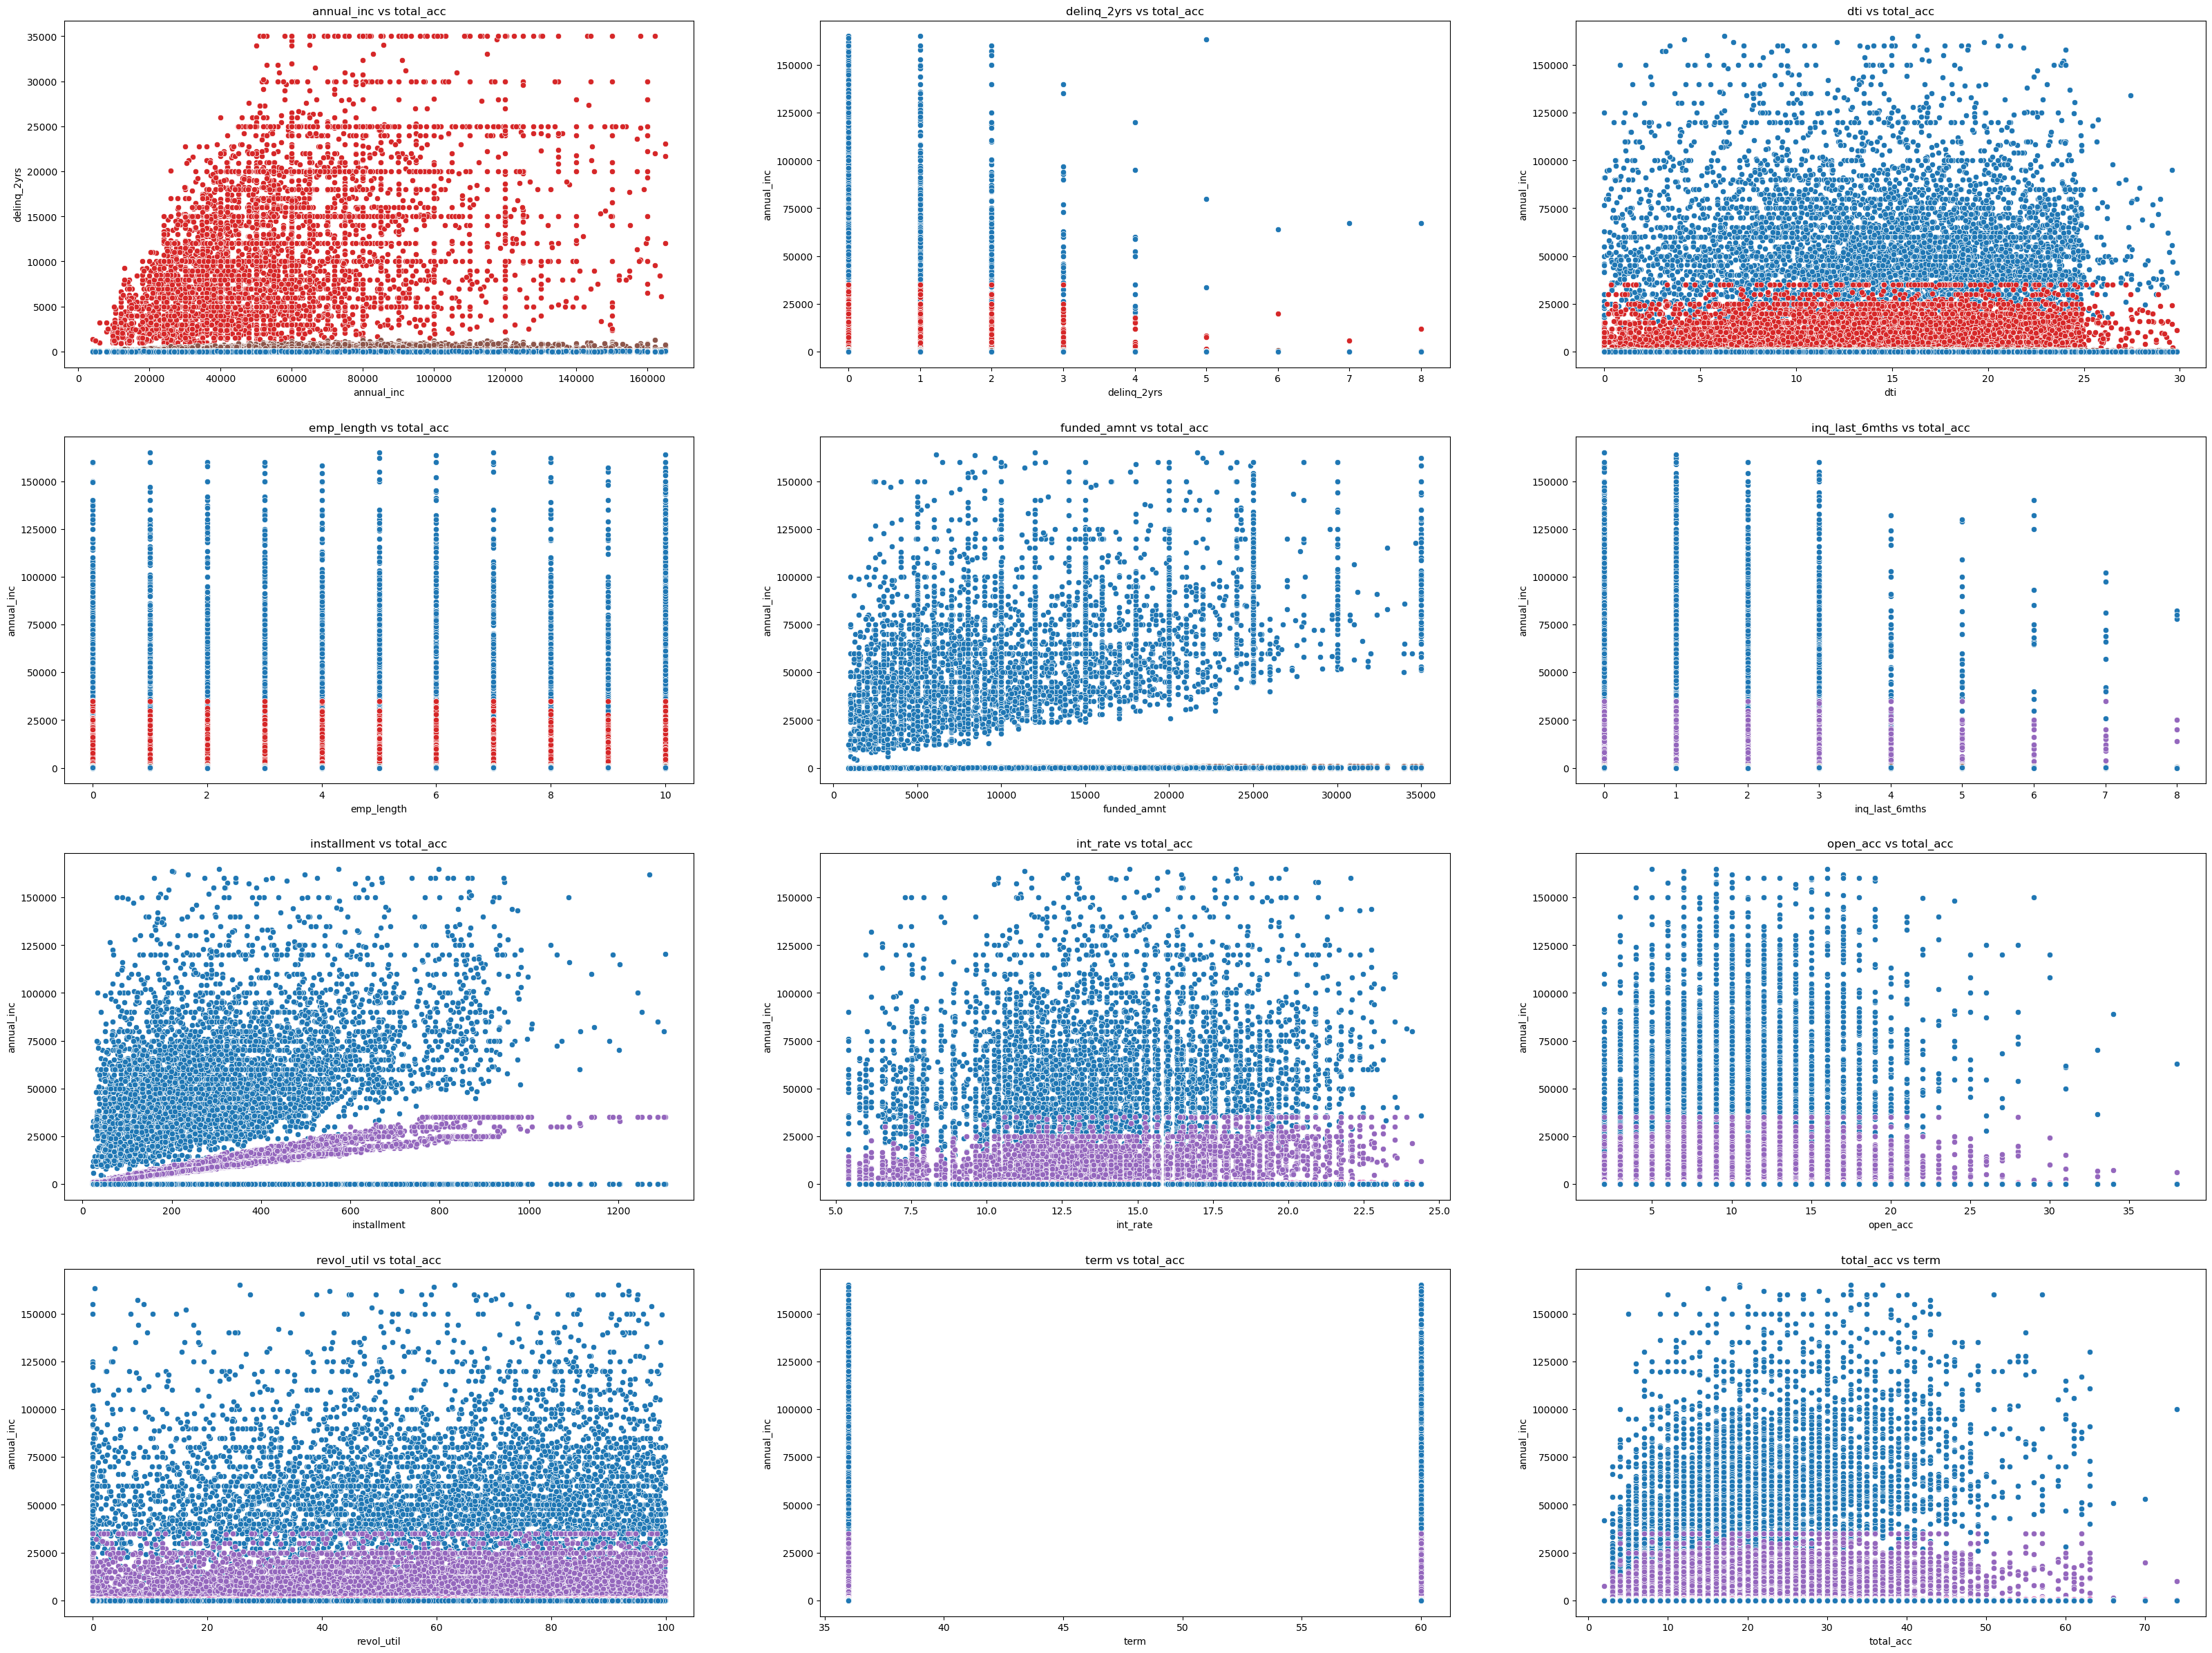

In [172]:
columns_to_plot=pd.Series(numerical_columns)
columns_to_plot = columns_to_plot[~columns_to_plot.isin(
    ['total_rec_prncp', 'total_rec_int', 'total_pymnt','revol_bal'
     'revol_util','revol_bal', 'pub_rec_bankruptcies','pub_rec'])]
ncols=3
nrows=round(np.ceil(len(columns_to_plot)/ncols))
fig, ax = plt.subplots(ncols= ncols,nrows=nrows, figsize=(40, 30))
ax = ax.flatten()
for index, col_1 in enumerate(columns_to_plot):
    for col_2 in columns_to_plot:
        if col_1 != col_2:
            sns.scatterplot(
                x=charged_off_loan_data[col_1],
                y=charged_off_loan_data[col_2],
                ax=ax[index]
                )
            ax[index].set_title(f'{col_1} vs {col_2}')
           
plt.show()

# 7 - Multivariate Analysis

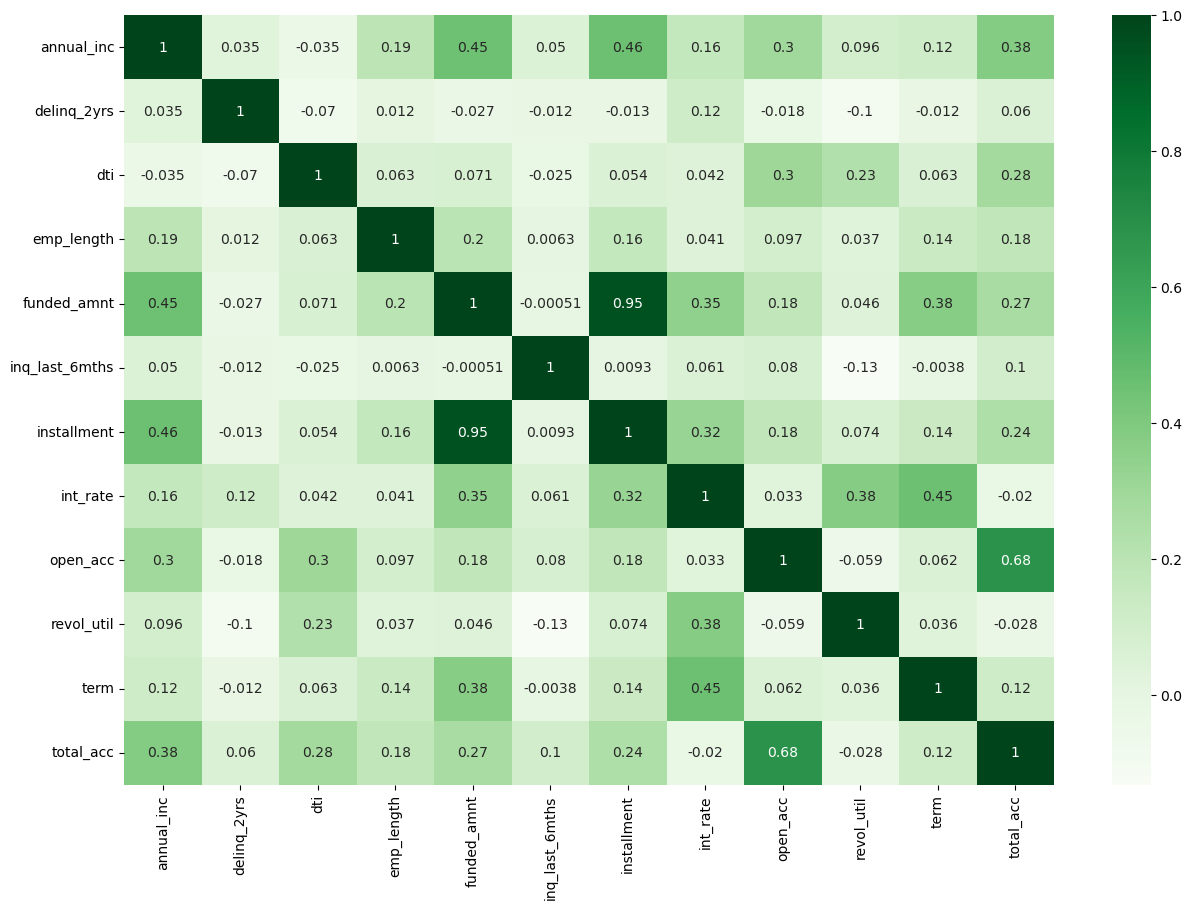

In [173]:
# numeric_columns = charged_off_loan_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
# display(numeric_columns)
columns_to_plot=pd.Series(numerical_columns)
columns_to_plot = columns_to_plot[~columns_to_plot.isin(
    ['total_rec_prncp', 'total_rec_int', 'total_pymnt','revol_bal'
     'revol_util','revol_bal', 'pub_rec_bankruptcies','pub_rec'])]
df  = charged_off_loan_data[columns_to_plot]
corr = df.corr()
# sns.clustermap(corr, annot=True, figsize=(12, 8), cmap="Greens")
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(corr,annot=True, cmap="Greens")
plt.show()

1. installment has a strong correlation with funded_amnt.
2. term has a correlation with interest rate and funded_amnt.
3. annual_inc has a correlation with funded_amnt.
4. dti has weak correlation with most of the fields.
5. annual_inc has a negative correlation with dti

# End of the Analysis